<a href="https://colab.research.google.com/github/werd0n4/hand-gesture-classification/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

---


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# !ls
# !cat /proc/cpuinfo
# !cat /proc/meminfo
# !nvidia-smi

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import os
import cv2
import glob
import random
import math
from matplotlib import pyplot as plt

# Constant parameters

---



## Image resolution

In [ ]:
horiz_x = 800  
vert_y = 600
dim_z = 3
# horiz_x = 640  
# vert_y = 480

In [ ]:
batch_size = 16
image_shape = (horiz_x, vert_y, dim_z)
early_stop = EarlyStopping(monitor='val_loss', patience=5)


## Paths


In [ ]:
model_path = '/content/drive/My Drive/Colab Notebooks/Zapisane modele/hand_gesture_classifier_rgb.h5'
dot_img_file = '/content/drive/My Drive/Colab Notebooks/model.png'

#drive paths
# imgs_train_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Train/'
# imgs_test_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Test/'

#local paths windows
# imgs_train_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'
# imgs_test_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'

#local paths manjaro
# imgs_train_path = '/home/werdon4/Rozszerzony_dataset/Train'
# imgs_test_path = '/home/werdon4/Rozszerzony_dataset/Test'

#skin data set
# imgs_train_path = '/content/drive/My Drive/Colab Notebooks/skin dataset/Train/'
# imgs_test_path = '/content/drive/My Drive/Colab Notebooks/skin dataset/Test/'

#binary images data set
# imgs_train_path = '/content/drive/My Drive/Colab Notebooks/skin_detector/zdjecia_czarnobiale/Train/'
# imgs_test_path = '/content/drive/My Drive/Colab Notebooks/skin_detector/zdjecia_czarnobiale/Test/'

#skin segmentation data set
imgs_train_path = '/content/drive/My Drive/Colab Notebooks/skin_detector/zdjecia_skora/Train/'
imgs_test_path = '/content/drive/My Drive/Colab Notebooks/skin_detector/zdjecia_skora/Test/'

# Auxiliary functions

---


## Image resize

In [ ]:
def img_counter(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        img_counter += len(os.listdir(os.path.join(path, dirname)))

    print("Images in set: " + str(img_counter))
    return img_counter


def resize(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            resized_img = cv2.resize(img, (horiz_x, vert_y))
            cv2.imwrite(image_path, resized_img)
            img_counter += 1
    
    print('Images in set: ' + str(img_counter))


## Image size sanity check

In [ ]:

def sanity_check(path):
    counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            if img.shape != (horiz_x, vert_y, 3):
                counter += 1

    print('Sanity result: ' + str(counter))

## Show image

In [ ]:

def show_img(i, path):
    testlist = glob.glob(f'{path}/*/*')
    img = cv2.normalize(cv2.imread(testlist[i]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32'))
    plt.show()
    label = testlist[i].split('/')[8]
    # label = label.split('_')[1]
    print("Gesture: " + str(label))

    # return img

# show_img(100)


## Load dataset

In [ ]:

def load_dataset():
    trainlist = glob.glob(f'{imgs_train_path}/*/*')
    testlist = glob.glob(f'{imgs_test_path}/*/*')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in trainlist] )
    X_test = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in testlist] )

    # Y_train = np.array([np.zeros(27) for fname in trainlist])
    Y_train = np.array([0 for fname in trainlist])
    for i,fname in enumerate(trainlist):
        # print(fname)
        img_id = fname.split('/')[7]##7 if windows 4 if manjaro
        img_id = img_id.split('_')[0]
        # Y_train[i][img_id] = 1
        Y_train[i] = img_id


    # Y_test = np.array([np.zeros(27) for fname in testlist])
    Y_test = np.array([0 for fname in testlist])
    for i,fname in enumerate(testlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_test[i][img_id] = 1
        Y_test[i] = img_id

    return X_train, Y_train, X_test, Y_test

# load_dataset()


# Create network model

---

In [ ]:

model = Sequential()
# kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05)
# kernel_initializer=None 
# initializer = initializers.GlorotUniform()
initializer = None
# regularizer = regularizers.l2(l2=0.01)
regularizer = None
activ_func = 'relu'
# kernel_regularizer=None
# activity_regularizer=None

# CONVOLUTIONAL LAYER - 1
model.add(Conv2D(
    filters=6, 
    kernel_size=(5,5), 
    input_shape=image_shape, 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer,
    # activity_regularizer=activity_regularizer
))
# CONVOLUTIONAL LAYER - 2
model.add(Conv2D(
    filters=6, 
    kernel_size=(5,5), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 1
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 3
model.add(Conv2D(
    filters=16, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))
# CONVOLUTIONAL LAYER - 4
model.add(Conv2D(
    filters=16, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 2
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 5
model.add(Conv2D(
    filters=32, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 3
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 6
model.add(Conv2D(
    filters=60, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 4
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))
# CONVOLUTIONAL LAYER - 6
model.add(Conv2D(
    filters=80, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 4
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 7
model.add(Conv2D(
    filters=120, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 5
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

######## FLATTEN ########
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(27, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    # optimizer='adam', 
    # optimizer=SGD(lr=0.01),
    optimizer='rmsprop',
    metrics=['accuracy']
)


## Model summary

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 796, 596, 6)       456       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 792, 592, 6)       906       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 396, 296, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 394, 294, 16)      880       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 392, 292, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 196, 146, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 194, 144, 32)      4

In [ ]:
# plot_model(model, to_file=dot_img_file, show_shapes=True, show_layer_names=False)

# Loading dataset

---


## Resize images and do sanity check

In [ ]:
# Uncomment before first run on dataset 
# resize(imgs_train_path)
# sanity_check(imgs_train_path)
# resize(imgs_test_path)
# sanity_check(imgs_test_path)
train_set_size = img_counter(imgs_train_path)
test_set_size = img_counter(imgs_test_path)


Images in set: 1640
Images in set: 432


## Load dataset to host memory

In [ ]:
# X_train, Y_train, X_test, Y_test = load_dataset()

## Convert labels to one hot encoding

In [ ]:
# Y_cat_train = to_categorical(Y_train, 27)
# Y_cat_test = to_categorical(Y_test, 27)

# Data augumentation

---

## Initializing ImageDataGenerator class

In [ ]:
image_gen = ImageDataGenerator(rotation_range=5, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                            #    rescale=1./255, # Rescale the image by normalzing it.
                               shear_range=0.05, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 10% max
                               fill_mode='nearest') # Fill in missing pixels with the nearest filled value
                              

## Augumentation sample result

In [ ]:
#original img
# nmb = random.randint(0, 296)
# my_hand = X_test[nmb]
# show_img(nmb, X_test, Y_cat_test)

# #generated img
# gen_img = image_gen.random_transform(my_hand)
# print("Generated image")
# plt.imshow(cv2.cvtColor(gen_img,cv2.COLOR_BGR2RGB).astype('float32'))
# plt.show()

# comparison = my_hand == gen_img
# equal_arrays = comparison.all()
# print("Images are equal?: " + str(equal_arrays))

## Initializing test and train image geneartors

In [ ]:
train_image_gen = image_gen.flow_from_directory(imgs_train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 1640 images belonging to 27 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(imgs_test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=1,
                                               class_mode='categorical',shuffle=False)

Found 432 images belonging to 27 classes.


In [ ]:
train_image_gen.class_indices

{'1': 0,
 '2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 'A': 5,
 'B': 6,
 'C': 7,
 'D': 8,
 'E': 9,
 'F': 10,
 'G': 11,
 'H': 12,
 'I': 13,
 'K': 14,
 'L': 15,
 'M': 16,
 'N': 17,
 'O': 18,
 'P': 19,
 'R': 20,
 'S': 21,
 'T': 22,
 'U': 23,
 'W': 24,
 'Y': 25,
 'Z': 26}

# Train model

---


## Load model from file

In [ ]:
# model = load_model(model_path)
# model.load_weights(model_path)

## Fit model

In [ ]:
# model.fit(X_train, Y_cat_train, epochs=12, validation_data=(X_test, Y_cat_test), batch_size=batch_size, callbacks=[early_stop])

## Fit model with data augumentation

In [ ]:
results = model.fit(train_image_gen, epochs=64, validation_data=test_image_gen, verbose=2)

Epoch 1/64
103/103 - 802s - loss: 3.4480 - accuracy: 0.0396 - val_loss: 3.2956 - val_accuracy: 0.0417
Epoch 2/64
103/103 - 217s - loss: 3.3081 - accuracy: 0.0402 - val_loss: 3.3004 - val_accuracy: 0.0370
Epoch 3/64
103/103 - 218s - loss: 3.3002 - accuracy: 0.0378 - val_loss: 3.2751 - val_accuracy: 0.0671
Epoch 4/64
103/103 - 216s - loss: 3.2128 - accuracy: 0.0720 - val_loss: 2.9922 - val_accuracy: 0.1273
Epoch 5/64
103/103 - 213s - loss: 2.9987 - accuracy: 0.1305 - val_loss: 2.7357 - val_accuracy: 0.2060
Epoch 6/64
103/103 - 213s - loss: 2.8172 - accuracy: 0.1695 - val_loss: 2.5602 - val_accuracy: 0.2639
Epoch 7/64
103/103 - 210s - loss: 2.6132 - accuracy: 0.2360 - val_loss: 2.2690 - val_accuracy: 0.3218
Epoch 8/64
103/103 - 212s - loss: 2.4080 - accuracy: 0.2738 - val_loss: 2.2338 - val_accuracy: 0.3009
Epoch 9/64
103/103 - 208s - loss: 2.2439 - accuracy: 0.3280 - val_loss: 2.1323 - val_accuracy: 0.3588
Epoch 10/64
103/103 - 213s - loss: 2.1284 - accuracy: 0.3567 - val_loss: 1.9156 - 

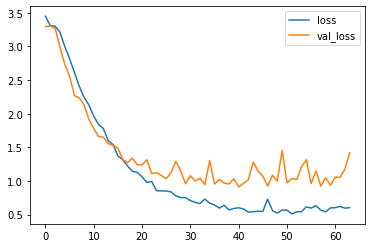

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss', 'val_loss']].plot()

losses.to_csv('/content/drive/My Drive/Colab Notebooks/losses.csv')

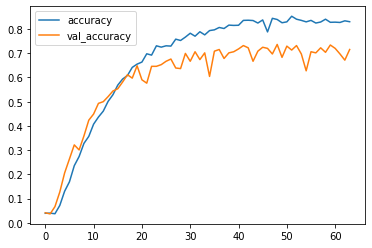

In [ ]:
losses.head()
losses[['accuracy', 'val_accuracy']].plot()
# losses.to_csv('/content/drive/My Drive/Colab Notebooks/losses_no_mask.csv')

## Saving model to file

In [ ]:
# model.save(model_path)

# Results

---


In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,3.447972,0.039634,3.295616,0.041667
1,3.308054,0.040244,3.300401,0.037037
2,3.300163,0.037805,3.275103,0.067130
3,3.212760,0.071951,2.992158,0.127315
4,2.998739,0.130488,2.735658,0.206019
...,...,...,...,...
59,0.600151,0.827439,0.934594,0.733796
60,0.602692,0.828049,1.057862,0.719907
61,0.622079,0.826829,1.051610,0.696759
62,0.595060,0.833537,1.177039,0.671296


## Single image prediction

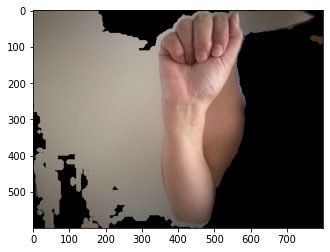

Gesture: A
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 99.99%
B: 0.01% C: 0.0% D: 0.0% E: 0.0% F: 0.0%
G: 0.0% H: 0.0% I: 0.0% K: 0.0% L: 0.0%
M: 0.0% N: 0.0% O: 0.0% P: 0.0% R: 0.0%
S: 0.0% T: 0.0% U: 0.0% W: 0.0% Y: 0.0%
Z: 0.0% 
CNN says: A


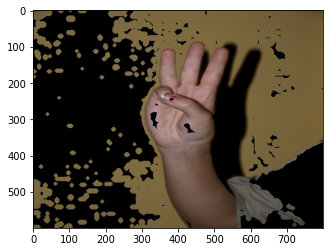

Gesture: W
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 0.04%
B: 0.0% C: 0.0% D: 0.0% E: 0.0% F: 0.0%
G: 0.0% H: 0.35% I: 0.0% K: 0.04% L: 0.0%
M: 0.0% N: 0.0% O: 0.0% P: 0.0% R: 0.09%
S: 0.0% T: 0.0% U: 0.01% W: 86.64% Y: 9.37%
Z: 3.44% 
CNN says: W


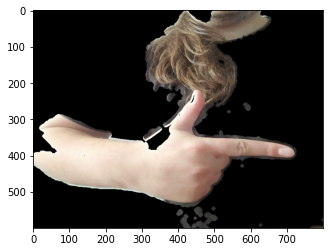

Gesture: 2
Class prediction: 
1: 0.02% 2: 88.25% 3: 11.62% 4: 0.0% 5: 0.0% A: 0.0%
B: 0.0% C: 0.0% D: 0.0% E: 0.0% F: 0.0%
G: 0.0% H: 0.0% I: 0.0% K: 0.0% L: 0.0%
M: 0.0% N: 0.11% O: 0.0% P: 0.0% R: 0.0%
S: 0.0% T: 0.0% U: 0.0% W: 0.0% Y: 0.0%
Z: 0.0% 
CNN says: 2


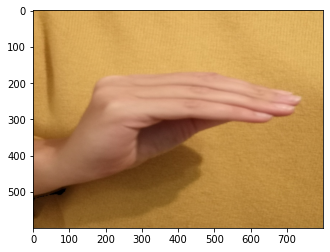

Gesture: E
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 0.0%
B: 0.0% C: 0.0% D: 0.0% E: 96.37% F: 0.0%
G: 0.0% H: 0.0% I: 0.0% K: 0.0% L: 0.01%
M: 0.0% N: 0.19% O: 0.0% P: 3.4% R: 0.0%
S: 0.0% T: 0.01% U: 0.0% W: 0.0% Y: 0.0%
Z: 0.0% 
CNN says: E


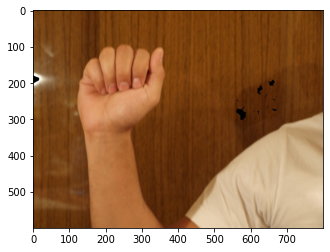

Gesture: A
Class prediction: 
1: 0.09% 2: 0.08% 3: 0.68% 4: 0.01% 5: 0.07% A: 64.97%
B: 32.25% C: 0.0% D: 0.0% E: 0.06% F: 0.96%
G: 0.0% H: 0.0% I: 0.13% K: 0.01% L: 0.44%
M: 0.0% N: 0.0% O: 0.01% P: 0.04% R: 0.03%
S: 0.02% T: 0.05% U: 0.02% W: 0.0% Y: 0.06%
Z: 0.0% 
CNN says: A


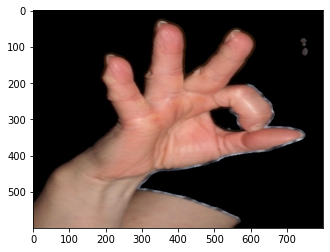

Gesture: S
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 0.0%
B: 0.0% C: 0.0% D: 0.0% E: 0.0% F: 0.0%
G: 0.0% H: 0.0% I: 0.0% K: 0.0% L: 0.0%
M: 0.0% N: 0.0% O: 97.04% P: 0.0% R: 0.0%
S: 0.39% T: 2.57% U: 0.0% W: 0.0% Y: 0.0%
Z: 0.0% 
CNN says: O


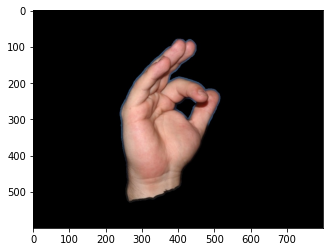

Gesture: F
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 0.0%
B: 0.0% C: 0.0% D: 0.0% E: 0.0% F: 0.02%
G: 0.0% H: 0.0% I: 0.0% K: 0.0% L: 0.0%
M: 0.0% N: 0.0% O: 99.97% P: 0.0% R: 0.0%
S: 0.0% T: 0.0% U: 0.0% W: 0.0% Y: 0.0%
Z: 0.0% 
CNN says: O


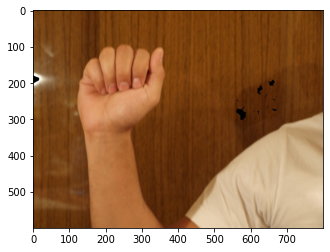

Gesture: A
Class prediction: 
1: 0.09% 2: 0.08% 3: 0.68% 4: 0.01% 5: 0.07% A: 64.97%
B: 32.25% C: 0.0% D: 0.0% E: 0.06% F: 0.96%
G: 0.0% H: 0.0% I: 0.13% K: 0.01% L: 0.44%
M: 0.0% N: 0.0% O: 0.01% P: 0.04% R: 0.03%
S: 0.02% T: 0.05% U: 0.02% W: 0.0% Y: 0.06%
Z: 0.0% 
CNN says: A


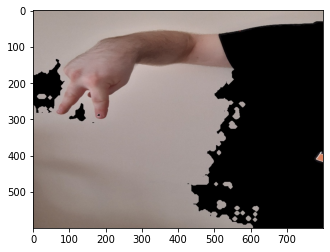

Gesture: U
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 0.06%
B: 0.0% C: 0.0% D: 0.0% E: 0.0% F: 0.0%
G: 0.0% H: 0.0% I: 0.0% K: 0.0% L: 0.0%
M: 0.0% N: 0.0% O: 0.0% P: 0.0% R: 0.0%
S: 0.0% T: 0.0% U: 99.94% W: 0.0% Y: 0.0%
Z: 0.0% 
CNN says: U


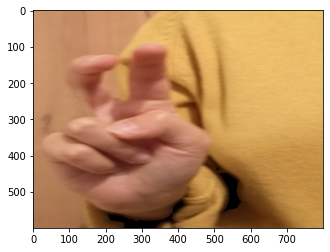

Gesture: H
Class prediction: 
1: 0.0% 2: 0.0% 3: 0.0% 4: 0.0% 5: 0.0% A: 0.0%
B: 0.0% C: 0.0% D: 0.0% E: 0.0% F: 0.0%
G: 0.0% H: 95.41% I: 0.0% K: 0.0% L: 0.0%
M: 0.0% N: 0.0% O: 0.0% P: 0.0% R: 3.6%
S: 0.0% T: 0.0% U: 0.0% W: 0.0% Y: 0.0%
Z: 0.99% 
CNN says: H


In [ ]:
imgslist = glob.glob(f'{imgs_test_path}/*/*')
class_names = list(train_image_gen.class_indices.keys())

for i in range(10):
    nmb = random.randint(1, test_set_size-1)
    show_img(nmb, imgs_test_path)
    single_img_path = imgslist[nmb]
    single_img = image.load_img(single_img_path, target_size=(horiz_x, vert_y, dim_z))
    single_img = image.img_to_array(single_img)
    single_img = np.expand_dims(single_img, axis=0)
    prediction = model.predict(single_img)
    print('Class prediction: ')
    # print(prediction[0])
    for i, prc in enumerate(prediction[0]):
        if(i%5 == 0 and i != 0):
            end="\n"
        else:
            end=" "
        print(class_names[i] +": " + str(round(100*prc, 2)) + '%', end=end)
    prediction = np.argmax(prediction, axis=-1)
    print('\nCNN says: ' + class_names[int(prediction)])




## Prediction statistics for individual classes

In [ ]:
# predictions = model.predict_classes(test_image_gen)
predictions = np.argmax(model.predict(test_image_gen), axis=-1)
# predict_file = pd.DataFrame(classification_report(test_image_gen.classes,predictions))
# predict_file.to_csv('/content/drive/My Drive/Colab Notebooks/class_predicts_no_mask.csv')

In [ ]:
report = classification_report(test_image_gen.classes,predictions)
print(report)

report_file = classification_report(test_image_gen.classes,predictions, output_dict=True)
print(report_file)
report_file = pd.DataFrame(report_file)
report_file.to_csv('/content/drive/My Drive/Colab Notebooks/class_predicts.csv')

              precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.62      0.50      0.55        16
           2       0.61      0.69      0.65        16
           3       0.83      0.62      0.71        16
           4       0.80      1.00      0.89        16
           5       0.87      0.81      0.84        16
           6       0.90      0.56      0.69        16
           7       0.83      0.62      0.71        16
           8       0.83      0.94      0.88        16
           9       0.92      0.69      0.79        16
          10       0.83      0.31      0.45        16
          11       0.61      0.69      0.65        16
          12       0.80      0.75      0.77        16
          13       0.65      0.69      0.67        16
          14       0.87      0.81      0.84        16
          15       1.00      0.88      0.93        16
          16       0.92      0.75      0.83        16
          17       0.86    

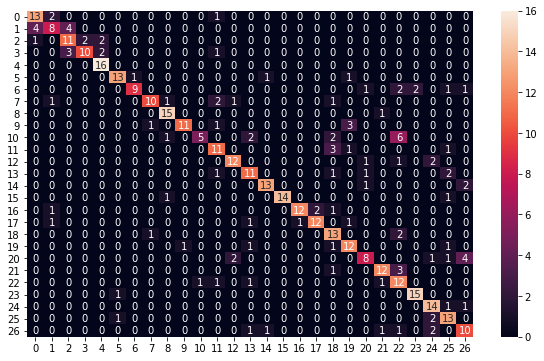

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(test_image_gen.classes,predictions),annot=True)
# confusion_matrix(test_image_gen.classes,predictions)

# Unmount Google drive

In [ ]:
# drive.flush_and_unmount()